TO DO : 

    - Separate data into metadata df and signal dict, so that it is easier to analyse data and to access signal just with key (sample_id) DONE
    -  Check for normal ecgs and train the classifier with AF vs normal (NORMAL ECGS ARE STATED AS SINUS RYTHM)
    - Only 100 samples are loaded for velocity. All should be loaded at the end

## Loading data

In [1]:
!python -V > full_requirements.txt && pip list --format=freeze >> full_requirements.txt

In [2]:
import os
import wfdb  # To read the .hea file
import scipy.io as sio  # To read .mat files
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, lfilter
import numpy as np
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import signal 
import pandas as pd


#Directories
dataset_dir = './a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords/03/032'
g_leads = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
fs = 500

In [3]:
disease_map_path = './a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/ConditionNames_SNOMED-CT.csv'
disease_map = pd.read_csv(disease_map_path)
disease_map = disease_map.set_index('Snomed_CT')
def disease_map_func(diagnosis, disease_map = disease_map):


    diagnosis = [disease_map.loc[int(code), "Full Name"] for code in diagnosis.split(',')]
    return diagnosis

In [4]:
ecg_data = {}
patient_data = {}

# Loop through each record in the dataset directory
for filename in os.listdir(dataset_dir):
    if filename.endswith(".hea"):  # Process .hea files
        record_name = filename.split(".")[0]

        # Read the header (.hea) file
        record = wfdb.rdheader(os.path.join(dataset_dir, record_name))

        # Extract metadata
        age = None
        sex = None
        diagnosis = None
        for comment in record.comments:
            if comment.startswith("Age:"):
                age = comment.split(":")[1].strip()
            if comment.startswith("Sex:"):
                sex = comment.split(":")[1].strip()
            if comment.startswith("Dx:"):
                diagnosis = comment.split(":")[1].strip()  # This gives you the SNOMED codes
        
        # Read the 12-lead ECG signal from the .mat file
        mat_file_path = os.path.join(dataset_dir, f"{record_name}.mat")
        mat_data = sio.loadmat(mat_file_path)
        ecg_signals = mat_data['val']  # 'val' typically holds the ECG signal in PhysioNet datasets
        ecg_signals= pd.DataFrame(ecg_signals.T, columns  = g_leads)
        # Store the data in the dictionary
        ecg_data[record_name] = {
            "ecg_signals": ecg_signals,  # 12-lead ECG signals
            }
        patient_data[record_name] = {
            "diagnosis_code": [disease for disease in diagnosis.split(',')],  # Disease label (SNOMED codes)
            "diagnosis_name": disease_map_func(diagnosis),
            "age": age,
            "sex": sex
        }



In [5]:
disease_map

,Acronym Name,Full Name
Snomed_CT,,
270492004,1AVB,1 degree atrioventricular block
195042002,2AVB,2 degree atrioventricular block
54016002,2AVB1,2 degree atrioventricular block(Type one)
28189009,2AVB2,2 degree atrioventricular block(Type two)
27885002,3AVB,3 degree atrioventricular block
...,...,...
713422000,AT,Atrial Tachycardia
233896004,AVNRT,Atrioventricular Node Reentrant Tachycardia
233897008,AVRT,Atrioventricular Reentrant Tachycardia


In [6]:
patient_data

{'JS02314': {'diagnosis_code': ['426177001'],
  'diagnosis_name': ['Sinus Bradycardia'],
  'age': '51',
  'sex': 'Female'},
 'JS02300': {'diagnosis_code': ['426177001'],
  'diagnosis_name': ['Sinus Bradycardia'],
  'age': '59',
  'sex': 'Male'},
 'JS02328': {'diagnosis_code': ['427084000'],
  'diagnosis_name': ['Sinus Tachycardia'],
  'age': '23',
  'sex': 'Female'},
 'JS02329': {'diagnosis_code': ['427084000'],
  'diagnosis_name': ['Sinus Tachycardia'],
  'age': '81',
  'sex': 'Male'},
 'JS02301': {'diagnosis_code': ['164889003', '164934002'],
  'diagnosis_name': ['Atrial Fibrillation', 'T wave Change'],
  'age': '89',
  'sex': 'Female'},
 'JS02315': {'diagnosis_code': ['164890007'],
  'diagnosis_name': ['Atrial Flutter'],
  'age': '64',
  'sex': 'Male'},
 'JS02303': {'diagnosis_code': ['426783006'],
  'diagnosis_name': ['Sinus Rhythm (Normal)'],
  'age': '56',
  'sex': 'Female'},
 'JS02317': {'diagnosis_code': ['164889003', '428750005'],
  'diagnosis_name': ['Atrial Fibrillation', 'S

## Funcitons

In [7]:
from scipy import signal
import scipy
import random
from scipy.signal import find_peaks, welch

def temp_freq_plot(signal, title):

    fig,ax = plt.subplots(12,2, figsize=(20,12*4))
    for i in range(0,12):
        _key = g_leads[i]
        #ax[i].set_title(_key)
        ax[i,0].plot(signal[_key], color='black', linewidth=0.6)
        ax[i,0].set_ylim((-1500,1500))
        ax[i,0].set_xticks(   np.arange(0,5001,500)  )   
        ax[i,0].set_xticklabels(   np.arange(0,5001,500)/fs  )   
        ax[i,0].grid(axis='x')
        ax[i,0].annotate(_key,(-200,0))
        #ax[i].set_xlabel('Time(sec)')
        #ax[i].set_ylabel('mV')
        ax[i,0].hlines(0,0,5000,color='black', linewidth=0.3)

        frequencies, psd_values = welch( signal[_key], fs, nperseg=1024)

        # Plotting the estimated PSD
        ax[i,1].semilogy(frequencies, psd_values)
        ax[i,1].set_title('Power Spectral Density (PSD) Estimate using Welch\'s Method')
        ax[i,1].set_xlabel('Frequency (Hz)')
        ax[i,1].set_ylabel('PSD (V^2/Hz)')

    plt.suptitle(f"{title}")
    plt.tight_layout()
    plt.show()




def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# Design a Notch Filter to remove 60 Hz power line interference
def notch_filter(frequency, fs, quality_factor=30):
    b, a = signal.iirnotch(frequency, quality_factor, fs)
    return b, a

def apply_notch_filter(data, frequency, fs, quality_factor=30):
    b, a = notch_filter(frequency, fs, quality_factor)
    y = signal.filtfilt(b, a, data)
    return y


def scipy_notch_filter(data, fs, frequency, quality):
    return scipy.signal.filtfilt(*scipy.signal.iirnotch(frequency / (fs / 2), quality), data)



Frequency response and plot of random patient

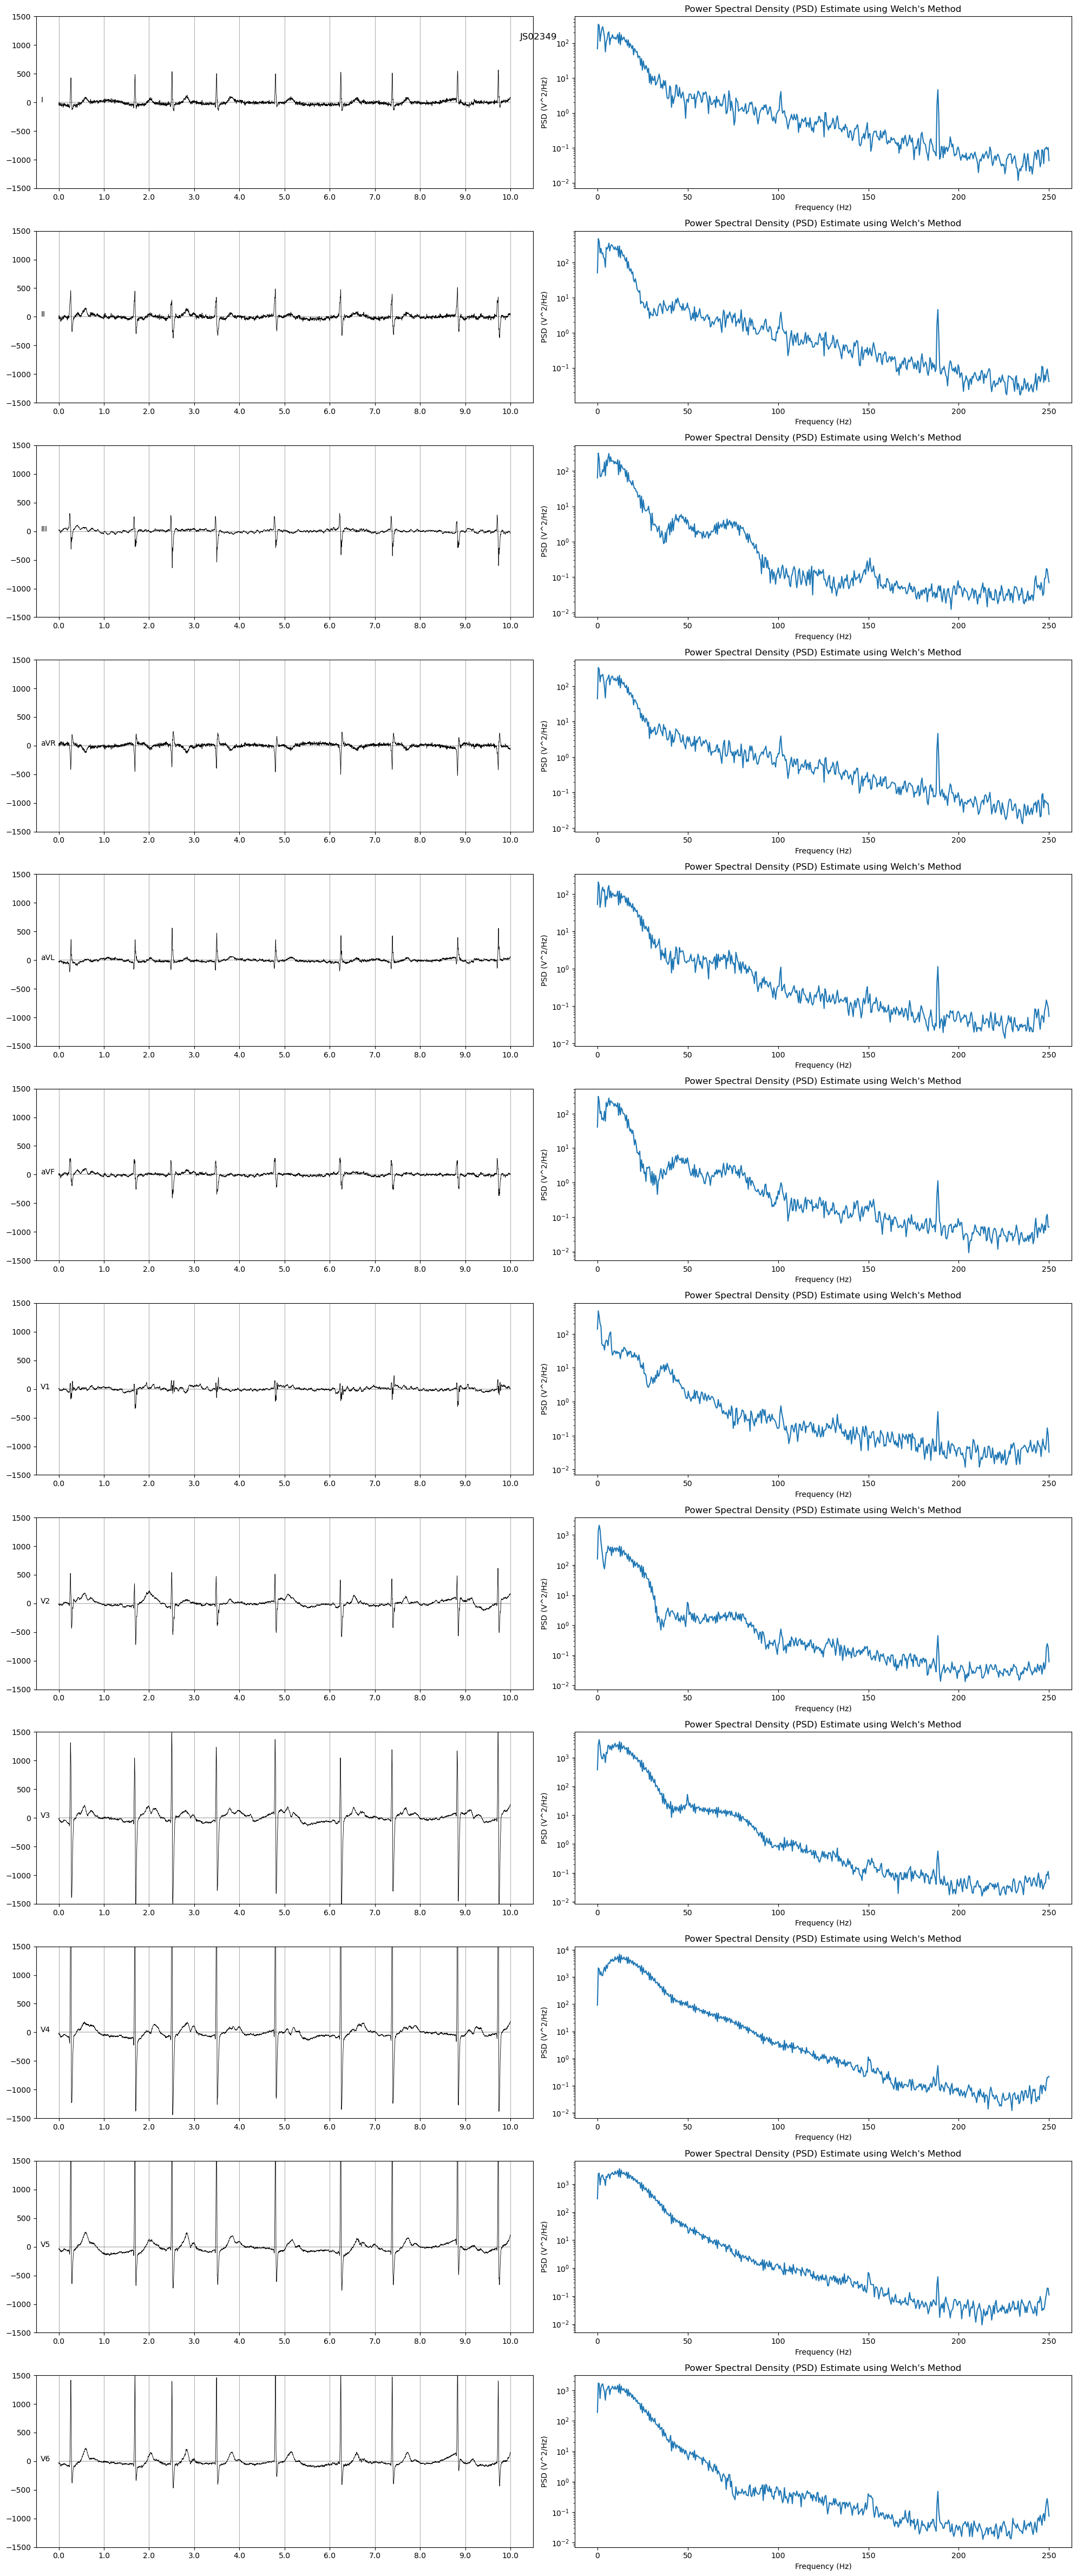

In [8]:
np.random.seed(42)  # Ensure reproducibility

random_patient = random.choice(list(ecg_data.keys()))
patient_signal = ecg_data[random_patient]["ecg_signals"]

temp_freq_plot(signal = patient_signal, title=random_patient)

## Filtering pipeline 

In [9]:
#applying filters
for patient in ecg_data.keys():

    filtered_signal = ecg_data[patient]['ecg_signals']#.apply(lambda x: signal.detrend(x))
    filtered_signal= filtered_signal.apply(lambda x:  signal.detrend(x))
    filtered_signal = filtered_signal.apply(lambda x: highpass_filter(data = x, cutoff=5, fs=fs))

    filtered_signal = filtered_signal.apply(lambda x: lowpass_filter(data = x, cutoff=140, fs=fs))
    filtered_signal = filtered_signal.apply(lambda x: scipy_notch_filter(data=x, frequency=50, fs=fs, quality=30))
    ecg_data[patient]['ecg_signals_filtered'] = filtered_signal

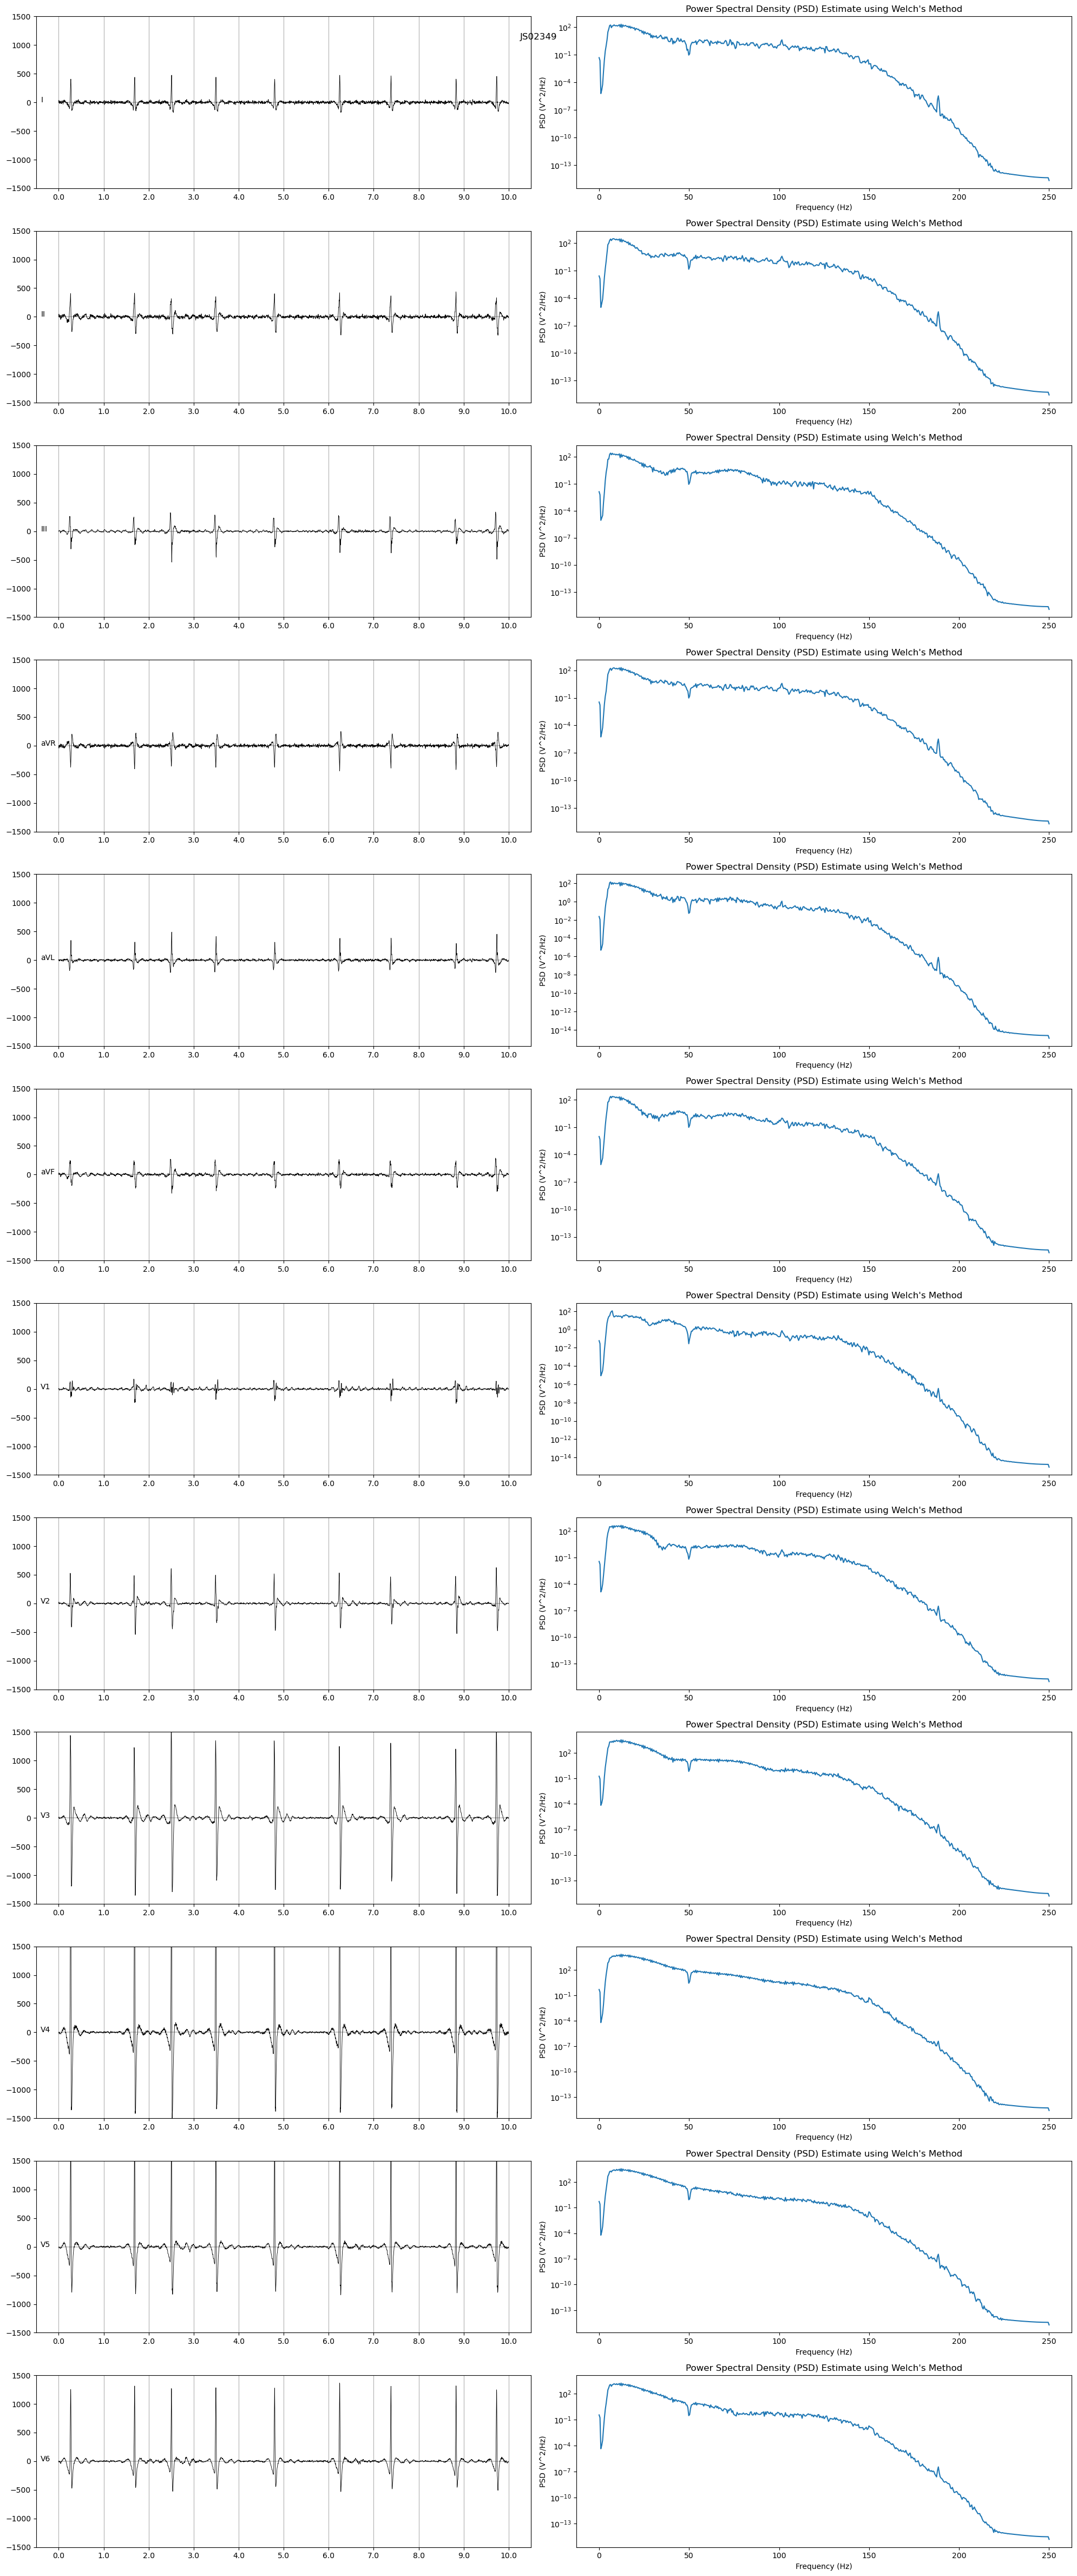

In [10]:
patient_signal_filtered = ecg_data[random_patient]['ecg_signals_filtered']

temp_freq_plot(signal = patient_signal_filtered, title = random_patient)

## Data distribution analysis


In [32]:
import sys
sys.path.append('/Users/marcpalomercadenas/Desktop/ML/utils')
%matplotlib inline
import auto_EDA as eda 

# The error says the diagnosis name is a series!!!!!!!!

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations

def prepare_data(data_dict):
    # Create a list to store the flattened data
    flattened_data = []
    
    for patient_id, info in data_dict.items():
        # Ensure diagnoses is a list and sort it
        diagnoses = info['diagnosis_name']
        if isinstance(diagnoses, str):
            diagnoses = [diagnoses]
        
        # Sort diagnoses to ensure consistent ordering
        sorted_diagnoses = sorted(diagnoses)
        
        # Create a string of sorted diagnosis combinations
        diagnosis_combination = ' & '.join(sorted_diagnoses)
        
        flattened_data.append({
            'patient_id': patient_id,
            'diagnosis_combination': diagnosis_combination,
            'age': int(info['age']),
            'sex': info['sex']
        })
    
    return pd.DataFrame(flattened_data)

# Create the three plots
def create_plots(df):
    # Set the style
    # plt.style.use('seaborn')
    
    # Create a figure with 3 subplots
    fig = plt.figure(figsize=(20, 6))
    
    # 1. Diagnosis Combinations Plot
    plt.subplot(131)
    diagnosis_counts = df['diagnosis_combination'].value_counts()
    sns.barplot(x=diagnosis_counts.values, y=diagnosis_counts.index)
    plt.title('Distribution of Diagnosis Combinations')
    plt.xlabel('Count')
    plt.ylabel('Diagnosis Combination')
    
    # 2. Age Distribution Plot
    plt.subplot(132)
    sns.histplot(data=df, x='age', bins=30, kde=True)
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Count')
    
    # 3. Gender Distribution Plot
    plt.subplot(133)
    sns.countplot(data=df, x='sex')
    plt.title('Gender Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    
    # Adjust layout
    plt.tight_layout()
    return fig

# Function to analyze and display the data
def analyze_ecg_data(data_dict):
    # Prepare the data
    df = prepare_data(data_dict)
    
    # Create and display the plots
    fig = create_plots(df)
    
    # Print some summary statistics
    print("\nSummary Statistics:")
    print("\nMost common diagnosis combinations:")
    print(df['diagnosis_combination'].value_counts().head())
    print("\nAge statistics:")
    print(df['age'].describe())
    print("\nGender distribution:")
    print(df['sex'].value_counts())
    
    return fig

# Example usage:
# Assuming your dictionary is called 'data'
# analyze_ecg_data(data)

# Example data for testing
example_data = {
    'JS02314': {'diagnosis_code': ['426177001','41309876'], 
                'diagnosis_name': ['Sinus Bradycardia', 'Normal ECG'], 
                'age': '51', 
                'sex': 'Female'},
    'JS02315': {'diagnosis_code': ['426177001'], 
                'diagnosis_name': ['Sinus Bradycardia'], 
                'age': '45', 
                'sex': 'Male'},
    'JS02316': {'diagnosis_code': ['41309876'], 
                'diagnosis_name': ['Normal ECG'], 
                'age': '62', 
                'sex': 'Female'}
}

# Uncomment to run with example data:
fig = analyze_ecg_data(patient_data)
plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [41]:
prepare_data(patient_data)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

# Filtering patients
# Distinctive Electrocardiographic Features of Atrial Fibrillation in 12-Lead ECG: A Differential Analysis

## Introduction

Atrial fibrillation (AF) presents distinctive electrocardiographic patterns that facilitate its differentiation from other cardiac arrhythmias. The systematic analysis of these characteristics in a 12-lead ECG enables accurate diagnosis and appropriate therapeutic intervention.

## Pathognomonic ECG Characteristics

### 1. R-R Interval Pattern

The hallmark "irregularly irregular" ventricular response represents a fundamental diagnostic criterion. This characteristic pattern manifests as:

* Complete irregularity in R-R intervals
* Absence of any discernible repetitive pattern
* Non-predictable sequence of ventricular complexes

### 2. P Wave Morphology

The absence of coordinated atrial depolarization results in:

* Complete absence of discrete P waves
* Replacement of normal P waves with fibrillatory waves
* Continuous undulation of the baseline without returning to an isoelectric line

### 3. Fibrillatory Wave Characteristics

The presence of distinctive f-waves exhibits the following features:

* Frequency: 350-600 oscillations per minute
* Morphology: Irregular, varying amplitude and shape
* Distribution: Most prominent in leads V1 and II
* Pattern: Continuous, chaotic baseline oscillation

## Differential Diagnostic Considerations

### 1. Distinction from Atrial Flutter

* Flutter presents regular, sawtooth F waves
* Demonstrates predictable ventricular response patterns
* Maintains consistent wave morphology

### 2. Differentiation from Multifocal Atrial Tachycardia

* MAT exhibits discrete, identifiable P waves
* Shows ≥3 distinct P wave morphologies
* Maintains irregular but potentially predictable rhythm

### 3. Contrast with Other Supraventricular Arrhythmias

* **Sinus arrhythmia:** Shows gradual, phasic rate variations
* **Premature atrial contractions:** Demonstrate interpolated ectopic beats with return to baseline rhythm
* **Wandering atrial pacemaker:** Exhibits progressive P wave morphology changes

---

*Note: This analysis provides a comprehensive framework for the identification and differentiation of atrial fibrillation from other cardiac arrhythmias through 12-lead ECG interpretation.*

In [26]:
# Define the conditions we want to keep
target_conditions = [['426783006'],  # Sinus Rhythm
                    ['164889003']]   # Atrial Fibrillation

# Filter the dictionary
filtered_data = {
    patient_id: data 
    for patient_id, data in patient_data.items() 
    if data['diagnosis_code'] in target_conditions
}

filtered_data

{'JS02303': {'diagnosis_code': ['426783006'],
  'diagnosis_name': ['Sinus Rhythm (Normal)'],
  'age': '56',
  'sex': 'Female'},
 'JS02312': {'diagnosis_code': ['426783006'],
  'diagnosis_name': ['Sinus Rhythm (Normal)'],
  'age': '77',
  'sex': 'Female'},
 'JS02305': {'diagnosis_code': ['426783006'],
  'diagnosis_name': ['Sinus Rhythm (Normal)'],
  'age': '81',
  'sex': 'Male'},
 'JS02377': {'diagnosis_code': ['426783006'],
  'diagnosis_name': ['Sinus Rhythm (Normal)'],
  'age': '67',
  'sex': 'Female'},
 'JS02376': {'diagnosis_code': ['426783006'],
  'diagnosis_name': ['Sinus Rhythm (Normal)'],
  'age': '49',
  'sex': 'Female'},
 'JS02360': {'diagnosis_code': ['426783006'],
  'diagnosis_name': ['Sinus Rhythm (Normal)'],
  'age': '31',
  'sex': 'Female'},
 'JS02372': {'diagnosis_code': ['426783006'],
  'diagnosis_name': ['Sinus Rhythm (Normal)'],
  'age': '74',
  'sex': 'Female'},
 'JS02366': {'diagnosis_code': ['426783006'],
  'diagnosis_name': ['Sinus Rhythm (Normal)'],
  'age': '45'

In [29]:
def plot_histogram(data, title=None, xlabel=None, color='#4A90E2', figsize=(10,6)):
    """
    Simple histogram with optional mean line.
    
    Parameters:
    data: array-like - Your data
    title: str - Plot title
    xlabel: str - X-axis label
    color: str - Bar color
    figsize: tuple - Figure size (width, height)
    """
    plt.figure(figsize=figsize)
    
    # Plot histogram
    plt.hist(data, bins='auto', color=color, alpha=0.7, edgecolor='white')
    
    # Add mean line
    mean = np.mean(data)
    plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
    
    # Labels
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel('Count')
    
    plt.legend()
    plt.show()

In [30]:
diagnosis = [patient_data['diagnosis'] for patient_data in ecg_data.values()]

counts = pd.Series(diagnosis).value_counts()

plt.figure(figsize=(10,6))
counts.plot(kind='bar')
plt.title('Counts')
plt.xticks(rotation=45)
plt.show()

KeyError: 'diagnosis'

In [31]:
ages = [int(patient_data['metadata']['age']) for patient_data in ecg_data.values()]
# Use it like:
plot_histogram(ages, title='Age Distribution', xlabel='Age')


KeyError: 'metadata'

Features Extracted:

Average Heart Rate (bpm): The average heart rate over the entire ECG recording.
RR Intervals (s): The time intervals between successive R-peaks.
SDNN (s): The standard deviation of the RR intervals, a common HRV metric.
RMSSD (s): The root mean square of successive differences of RR intervals, a measure of HRV.
LF Power: Power in the low-frequency band (0.04–0.15 Hz), associated with sympathetic modulation.
HF Power: Power in the high-frequency band (0.15–0.4 Hz), associated with parasympathetic (vagal) activity.
LF/HF Ratio: The ratio of low-frequency to high-frequency power, often used as a measure of autonomic balance.
Average ST-Segment Deviation: The average deviation of the ST segment after each R-peak, which can be indicative of ischemic conditions.


In [ ]:
import numpy as np
from scipy.signal import find_peaks, welch

# Helper functions from before
def detect_r_peaks_wfdb(ecg_signal, sampling_rate):
    r_peaks, _ = find_peaks(ecg_signal, distance=sampling_rate * 0.6)
    return r_peaks

def compute_rr_intervals_wfdb(r_peaks, sampling_rate):
    rr_intervals = np.diff(r_peaks) / sampling_rate
    return rr_intervals

def compute_heart_rate_wfdb(rr_intervals):
    hr = 60 / rr_intervals
    return hr

def compute_hrv_wfdb(rr_intervals):
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
    return sdnn, rmssd

def compute_psd_wfdb(ecg_signal, sampling_rate, nperseg=256):
    freqs, psd = welch(ecg_signal, fs=sampling_rate, nperseg=nperseg)
    return freqs, psd

def extract_frequency_band_power_wfdb(freqs, psd, band):
    band_power = np.trapz(psd[(freqs >= band[0]) & (freqs <= band[1])], freqs[(freqs >= band[0]) & (freqs <= band[1])])
    return band_power

def compute_st_segment_deviation_wfdb(ecg_signal, r_peaks, sampling_rate):
    st_deviation = []
    for r_peak in r_peaks:
        st_start = int(r_peak + 0.08 * sampling_rate)
        st_end = int(st_start + 0.06 * sampling_rate)
        if st_end < len(ecg_signal):
            st_segment = ecg_signal[st_start:st_end]
            st_deviation.append(np.mean(st_segment))
    return st_deviation

# Main function to apply feature extraction on the dataset
def extract_features_from_ecg(data, sampling_rate):
    results = {}

    for patient_id, patient_data in data.items():
        ecg_signals = patient_data['ecg_signals']
        ecg_filtered_signals = patient_data['ecg_signals_filtered']
        disease = patient_data['diagnosis']

        # Extract features using Lead II for time-domain and frequency-domain features
        lead_ii = ecg_filtered_signals['II'].values
        
        # Detect R-peaks and compute RR intervals (Lead II)
        r_peaks = detect_r_peaks_wfdb(lead_ii, sampling_rate)
        rr_intervals = compute_rr_intervals_wfdb(r_peaks, sampling_rate)

        # Calculate Heart Rate and HRV (Lead II)
        heart_rate = compute_heart_rate_wfdb(rr_intervals)
        avg_heart_rate = np.mean(heart_rate)
        sdnn, rmssd = compute_hrv_wfdb(rr_intervals)

        # Frequency domain features (Lead II)
        freqs, psd = compute_psd_wfdb(lead_ii, sampling_rate)
        lf_power = extract_frequency_band_power_wfdb(freqs, psd, band=(0.04, 0.15))
        hf_power = extract_frequency_band_power_wfdb(freqs, psd, band=(0.15, 0.4))
        lf_hf_ratio = lf_power / hf_power if hf_power != 0 else np.inf

        # ST-segment deviation for all leads
        st_deviations = {}
        for lead in ecg_filtered_signals.columns:
            st_deviations[lead] = compute_st_segment_deviation_wfdb(ecg_filtered_signals[lead].values, r_peaks, sampling_rate)

        avg_st_deviations = {f"Avg_ST_D_{lead}": np.mean(deviation) for lead, deviation in st_deviations.items() if len(deviation) > 0}

        # Collect results
        results[patient_id] = {
            "Average Heart Rate (bpm)": avg_heart_rate,
            # "RR Intervals (s)": rr_intervals,
            "SDNN (s)": sdnn,
            "RMSSD (s)": rmssd,
            # "LF Power": lf_power,
            # "HF Power": hf_power,
            # "LF/HF Ratio": lf_hf_ratio,
            "Diagnosis": disease
        }

        results[patient_id].update(avg_st_deviations)
    return results


# Assume a sampling rate of 500Hz (adjust according to actual data)
results = extract_features_from_ecg(ecg_data, fs)
features_df = pd.DataFrame.from_dict(results, orient='index')
print(features_df)



In [ ]:
diseases = pd.read_csv("/Users/marcpalomercadenas/Desktop/ML/ECG_prediction/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/ConditionNames_SNOMED-CT.csv")
diseases=diseases.rename(columns={"Snomed_CT": "Disease"})
diseases['Disease']=diseases['Disease'].astype(str)

In [ ]:
#Librerías:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:


y = features_df['Diagnosis']#.apply(lambda x: x.split(','))
X = features_df.loc[:,features_df.columns != 'Diagnosis'] 

# mlb = MultiLabelBinarizer()
# binary_labels = mlb.fit_transform(y)

# label_df = pd.DataFrame(binary_labels, columns=mlb.classes_)
# label_df

print(y.value_counts())
print(diseases[diseases['Disease'].isin(["426783006", "426177001", "427084000", "164889003", "164934002", "164890007"])])

y=y[y.isin(["426783006", "426177001"])]
X = X.loc[y.index]
print(y.value_counts())

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

label_to_color = {label: idx for idx, label in enumerate(np.unique(y))}
colors = [label_to_color[label] for label in y]

# Plotting the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors)
plt.title("PCA of Example Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
# plt.colorbar(scatter, label='Class Label')
plt.show()

Lets remake the feature extration!!!

In [ ]:
#Dividimos los conjuntos de entrenamiento(70%) y test(30). 
X_train, X_test, y_train, y_test = train_test_split(X, label_df, test_size=0.3, random_state=42)
# mlb.classes_
y_train

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Create a multi-label RandomForestClassifier
model = RandomForestClassifier()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
Y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, Y_pred)
f1 = f1_score(y_test, Y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


In [ ]:


#Modelos de clasificación
models = dict([("Random Forest", RandomForestClassifier()), 
          ('Logistic Regression', LogisticRegression(max_iter=10000)), 
          ('Support Vector Machine', SVC()),
          ('XGBoost', XGBClassifier()),
          ('LightGBM', LGBMClassifier())])

# Evaluar los modelos utilizando validación cruzada
for name, model in models.items():
    print(f'{name}:')
    # Volidación cruzada
    scores = cross_val_score(model, X_train, y_train, cv=7, scoring = 'balanced_accuracy')
    print(f'Mean cross-validation score: {scores.mean():.3f}')
    print(f'Standard deviation: {scores.std():.3f}')
  
    #Ajuste con train:
    model.fit(X_train, y_train)
    
    #Predicción con test:
    y_pred = model.predict(X_test)
    
    #Resultados
    accuracy = accuracy_score(y_test, y_pred)#Exactitud
    precision = precision_score(y_test, y_pred, average='weighted')#Precisión
    recall = recall_score(y_test, y_pred, average='weighted')
    
    print(f'Accuracy score on test data: {accuracy:.3f}')
    print(f'Precision score on test data: {precision:.3f}')
    print(f'Recall score on test data: {recall:.3f}\n')

#REPETIMOS CON LOS DATOS NORMALIZADOS:
print(' ')
print('With scaled data')
print(' ')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
normalizer = Normalizer().fit(X)
X_train_scaled=normalizer.transform(X_train_scaled)
X_test_scaled=normalizer.transform(X_test_scaled)

#Utilizamos los mismos modelos:
models = dict([("Random Forest", RandomForestClassifier()), 
          ('Logistic Regression', LogisticRegression(max_iter=10000)), 
          ('Support Vector Machine', SVC()),
          ('XGBoost', XGBClassifier()),
          ('LightGBM', LGBMClassifier())])

# Evaluar los modelos utilizando validación cruzada
for name, model in models.items():
    print(f'{name}:')
    
    # Validación cruzada
    scores = cross_val_score(model, X_train_scaled, y_train, cv=7, scoring='balanced_accuracy')
    print(f'Mean cross-validation score: {scores.mean():.3f}')
    print(f'Standard deviation: {scores.std():.3f}')
    
    model.fit(X_train_scaled, y_train) #Ajuste del modelo a los datos de entrenamiento escalados y las etiquetas. 
    
    #Predicción con los datos test escalados:
    y_pred = model.predict(X_test_scaled)
    
    #Resultados:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Accuracy score on test data: {accuracy:.3f}')
    print(f'Precision score on test data: {precision:.3f}')
    print(f'Recall score on test data: {recall:.3f}\n')

#print(X)a


In [ ]:
import pandas as pd
import numpy as np

# Sample DataFrame creation
data = {
    'Var1': [10, 12, 7, 14, 11, 9, 15, 13, 8, 17, 12, 10, 19, 14, 11, 16, 13, 12],
    'Var2': [5, 6, 4, 3, 8, 2, 7, 5, 6, 4, 9, 5, 8, 6, 7, 3, 10, 6],
    'Var3': [8, 9, 6, 7, 10, 5, 12, 11, 7, 9, 14, 6, 13, 10, 8, 11, 12, 9],
    'Var4': [1, 2, 3, 4, 5, 6, 8, 7, 2, 3, 6, 4, 5, 8, 7, 4, 5, 8],
    'Var5': [7, 5, 9, 6, 8, 10, 11, 9, 12, 10, 8, 7, 14, 9, 12, 11, 10, 8],
    'Cat1': ['a', 'b', 'c', 'd', 'e', 'f', 'a', 'b', 'c', 'd', 'e', 'f', 'a', 'b', 'c', 'd', 'e', 'f']
}
df = pd.DataFrame(data)

# 1. Intra-group Variability
intra_group_stats = df.groupby('Cat1').agg({
    'Var1': ['mean', 'std'],
    'Var2': ['mean', 'std'],
    'Var3': ['mean', 'std'],
    'Var4': ['mean', 'std'],
    'Var5': ['mean', 'std']
})

# Calculate CV (Coefficient of Variation)
for var in ['Var1', 'Var2', 'Var3', 'Var4', 'Var5']:
    intra_group_stats[(var, 'CV')] = (intra_group_stats[(var, 'std')] / intra_group_stats[(var, 'mean')]) * 100

# Flatten the multi-level columns
intra_group_stats.columns = ['_'.join(col).strip() for col in intra_group_stats.columns.values]

# Convert intra_group_stats to DataFrame
intra_group_df = intra_group_stats.reset_index()
print("Intra-group Variability:\n", intra_group_df)

# 2. Inter-group Variability
# Calculate the mean of means for each variable
group_means = df.groupby('Cat1').mean()

# Compute variance of group means across Cat1 groups
variance_between_groups = group_means.var()

# Calculate overall means for each variable
overall_means = df[['Var1', 'Var2', 'Var3', 'Var4', 'Var5']].mean()

# Calculate CV for the variance of group means
cv_between_groups = (variance_between_groups / overall_means) * 100

# Create a DataFrame for inter-group variability
inter_group_df = pd.DataFrame({
    'Variance_Between_Groups': variance_between_groups,
    'CV_Between_Groups': cv_between_groups
}).reset_index()

print("\nInter-group Variability:\n", inter_group_df)
